In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [2]:
# load data
df_X = pd.read_csv('../data/X.csv', index_col=0)
df_y = pd.read_csv('../data/y.csv', index_col=0)

y = df_y.values.ravel()  # 0 is HER2+, 1 is HR+, 2 is Triple Negative
category_labels = ['HER2+', 'HR+', 'Triple Neg']

In [3]:
def plot_confusion_matrix(y_test, y_pred, categories):
    """
    Plots a confusion matrix using seaborn to compare the ground truth labels
    and the model's predictions.

    Parameters:
    - y_test (array-like): True labels.
    - y_pred (array-like): Predictions from the model.
    - categories (list): List of category names for labeling the axes.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap from the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
def roc_plot(X_train, X_test, y_train, y_test, best_model):
    # Binarize the output
    y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(best_model)
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)

    plt.figure(figsize=(8, 6))
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def nested_cv_logreg(x_data, y_targets):
    # define the model
    log_reg = LogisticRegression(solver='liblinear', multi_class='ovr')

    # define the grid of hyperparameters
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'penalty': ['l1', 'l2'],
                  'max_iter': [100, 200, 300, 400, 500]}
    
    # configure the nested cross-validation procedure
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=2)

    outer_scores = []
    best_models = []
    num_splits = outer_cv.get_n_splits(x_data)
    current_split = 0

    for train_index, test_index in outer_cv.split(x_data):
        current_split += 1

        X_train, X_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_targets[train_index], y_targets[test_index]
        
        grid_search = GridSearchCV(log_reg, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_models.append(best_model)
        
        test_score = best_model.score(X_test, y_test)
        outer_scores.append(test_score)

        if current_split == num_splits:
            best_overall_model = best_models[np.argmax(outer_scores)]
            y_pred = best_overall_model.predict(X_test)
            # evaluation
            print(classification_report(y_test, y_pred))
            plot_confusion_matrix(y_test, y_pred, category_labels)
            roc_plot(X_train, X_test, y_train, y_test, best_overall_model)


    # Calculate the mean and standard deviation of the outer scores
    mean_accuracy = np.mean(outer_scores)
    std_accuracy = np.std(outer_scores)

    
    return {
        "mean_accuracy": mean_accuracy,
        "std_accuracy": std_accuracy,
        "best_model": best_overall_model,
        "all_models": best_models}

In [6]:
def nested_cv_knn(x_data, y_targets):
    # define the model
    knn = KNeighborsClassifier()

    # define the grid of hyperparameters
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11],
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    # configure the nested cross-validation procedure
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=2)

    outer_scores = []
    best_models = []
    num_splits = outer_cv.get_n_splits(x_data)
    current_split = 0

    for train_index, test_index in outer_cv.split(x_data):
        current_split += 1

        X_train, X_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_targets[train_index], y_targets[test_index]
        
        grid_search = GridSearchCV(knn, param_grid=param_grid, cv=inner_cv, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_models.append(best_model)
        
        test_score = best_model.score(X_test, y_test)
        outer_scores.append(test_score)

        if current_split == num_splits:
            best_overall_model = best_models[np.argmax(outer_scores)]
            y_pred = best_overall_model.predict(X_test)
            # evaluation
            print(classification_report(y_test, y_pred))
            plot_confusion_matrix(y_test, y_pred, category_labels)
            roc_plot(X_train, X_test, y_train, y_test, best_overall_model)


    # Calculate the mean and standard deviation of the outer scores
    mean_accuracy = np.mean(outer_scores)
    std_accuracy = np.std(outer_scores)

    
    return {
        "mean_accuracy": mean_accuracy,
        "std_accuracy": std_accuracy,
        "best_model": best_overall_model,
        "all_models": best_models}

def nested_cv_logreg(X, y):
    # define the model
    log_reg = LogisticRegression(solver='liblinear', multi_class='ovr')

    # define the grid of hyperparameters
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'penalty': ['l1', 'l2'],
                  'max_iter': [100, 200, 300, 400, 500]}
    
    # configure the nested cross-validation procedure
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=12345)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=12345)

    # search
    grid_search = GridSearchCV(log_reg, param_grid, cv=inner_cv)
    cross_val_scores = cross_val_score(grid_search, X, y, cv=outer_cv)

    # summarize the estimated performance of the model
    print("Mean cross-validation score:", np.mean(cross_val_scores), "+/-", np.std(cross_val_scores))

    return grid_search.best_estimator_

def nested_cv_knn(X, y):
    # define the model
    knn = KNeighborsClassifier()

    # define the grid of hyperparameters
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11],
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}

    # configure the nested cross-validation procedure
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=12345)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=12345)

    # search
    grid_search = GridSearchCV(knn, param_grid, cv=inner_cv)
    cross_val_scores = cross_val_score(grid_search, X, y, cv=outer_cv)

    print("Mean cross-validation score:", np.mean(cross_val_scores))

    return grid_search.best_estimator_

# All features

In [7]:
X = df_X.to_numpy()

## Logistic regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        12

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



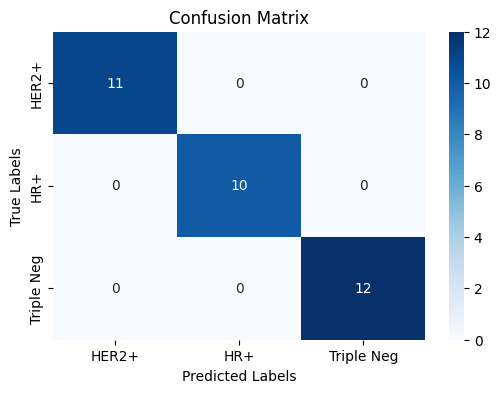

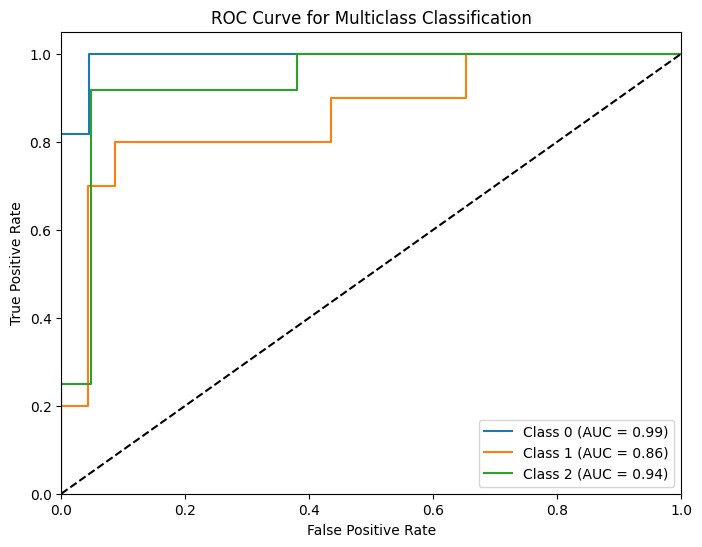

{'mean_accuracy': 0.8496732026143792,
 'std_accuracy': 0.0262112240048874,
 'best_model': LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear'),
 'all_models': [LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear'),
  LogisticRegression(C=10, max_iter=300, multi_class='ovr', penalty='l1',
                     solver='liblinear'),
  LogisticRegression(C=100, max_iter=300, multi_class='ovr', penalty='l1',
                     solver='liblinear')]}

In [8]:
nested_cv_logreg(X,y)

## kNN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        12

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



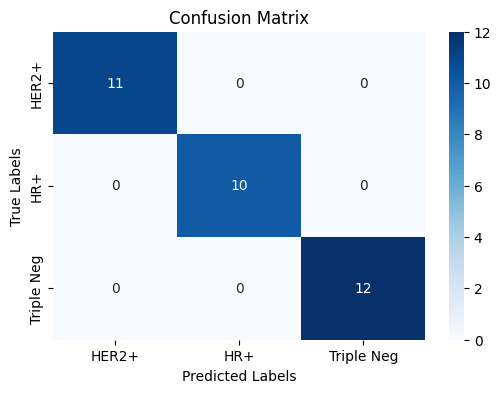

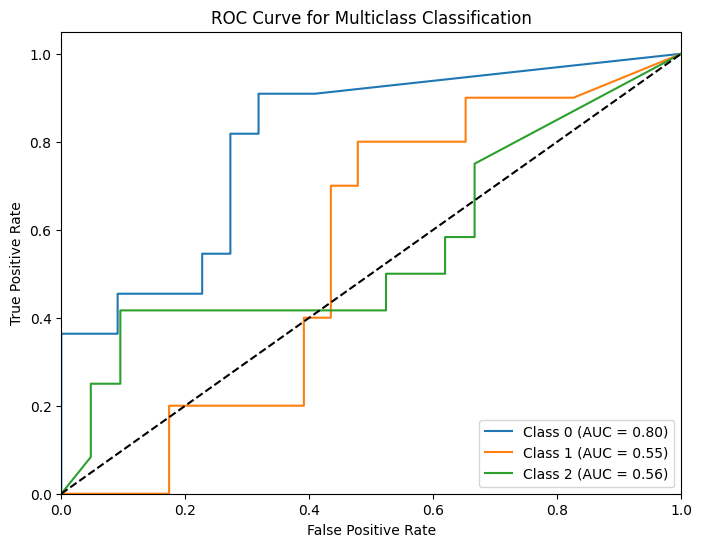

{'mean_accuracy': 0.41978609625668445,
 'std_accuracy': 0.019540206360553,
 'best_model': KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'),
 'all_models': [KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'),
  KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'),
  KNeighborsClassifier(weights='distance')]}

In [9]:
nested_cv_knn(X,y)

# List 2

In [10]:
# keep selected columns
list_2 = [1902, 1956, 1973, 2026, 2058, 2183, 2184, 2207, 2211, 2213, 2547, 2593, 1672, 118, 192, 695, 772, 791, 854, 1061, 1091, 1559, 1643, 1656, 1678, 1900, 2017, 2021, 2024, 2210, 2218, 2750, 2776, 2791, 2817, 2825]
new_df_X = df_X.iloc[:, list_2]

X = new_df_X.to_numpy()

## Logistic regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        12

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



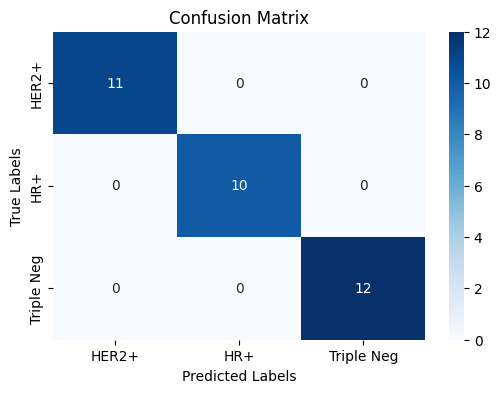

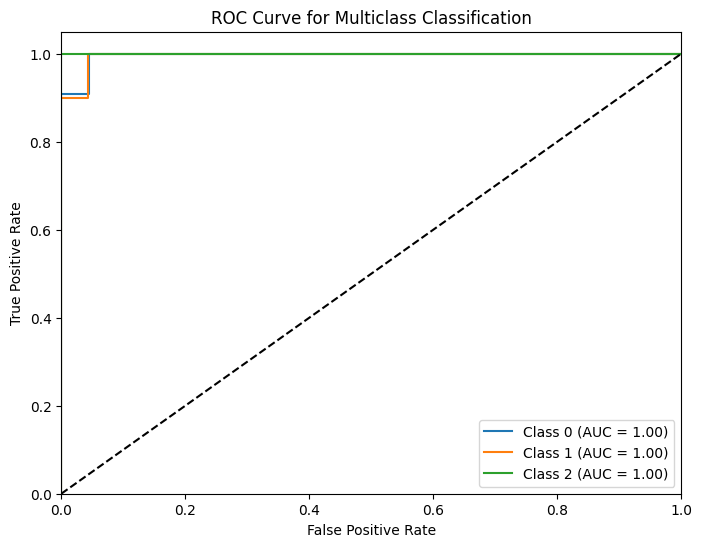

{'mean_accuracy': 0.9396910279263221,
 'std_accuracy': 0.04306656684580095,
 'best_model': LogisticRegression(C=0.1, multi_class='ovr', solver='liblinear'),
 'all_models': [LogisticRegression(C=0.1, multi_class='ovr', solver='liblinear'),
  LogisticRegression(C=0.1, multi_class='ovr', solver='liblinear'),
  LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear')]}

In [11]:
nested_cv_logreg(X,y)

## kNN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        12

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



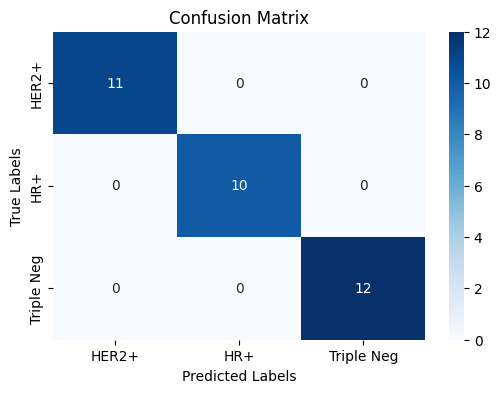

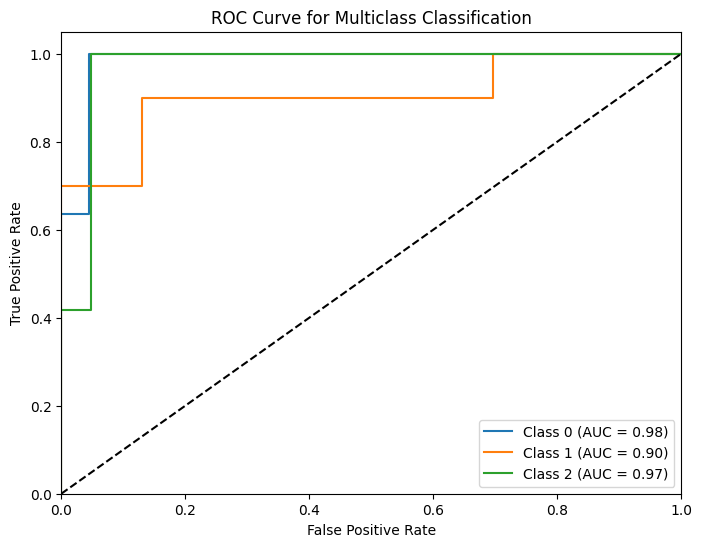

{'mean_accuracy': 0.8398692810457516,
 'std_accuracy': 0.015442889386057044,
 'best_model': KNeighborsClassifier(n_neighbors=11, weights='distance'),
 'all_models': [KNeighborsClassifier(n_neighbors=11, weights='distance'),
  KNeighborsClassifier(n_neighbors=3, weights='distance'),
  KNeighborsClassifier(n_neighbors=3)]}

In [12]:
nested_cv_knn(X, y)

# List 3

In [13]:
# keep selected columns
list_3 = [2026, 2184, 2213, 791, 1656, 1678, 1900, 2750]
new_df_X = df_X.iloc[:, list_3]

X = new_df_X.to_numpy()

## Logistic regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.80      0.89        10
           2       0.86      1.00      0.92        12

    accuracy                           0.94        33
   macro avg       0.95      0.93      0.94        33
weighted avg       0.95      0.94      0.94        33



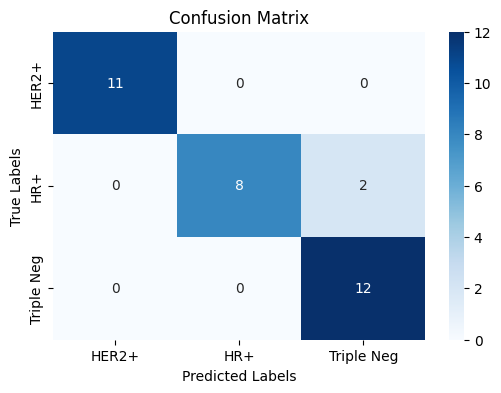

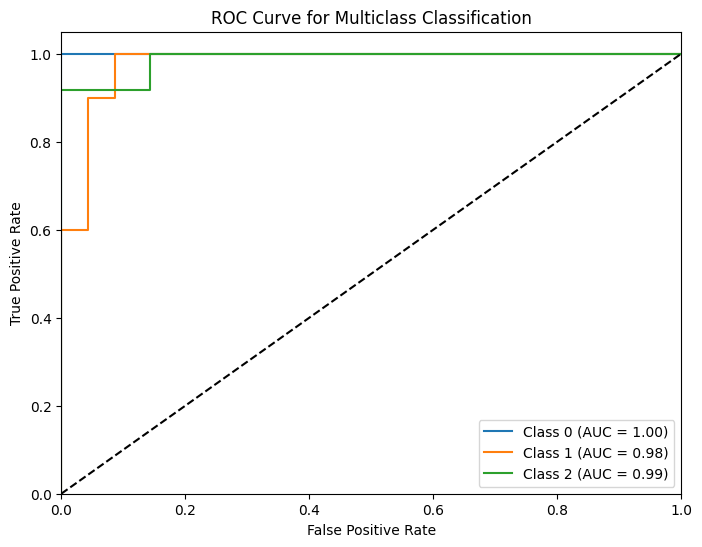

{'mean_accuracy': 0.9093879976232917,
 'std_accuracy': 0.043275103067269394,
 'best_model': LogisticRegression(C=1, multi_class='ovr', solver='liblinear'),
 'all_models': [LogisticRegression(C=1, multi_class='ovr', solver='liblinear'),
  LogisticRegression(C=1, multi_class='ovr', solver='liblinear'),
  LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear')]}

In [14]:
nested_cv_logreg(X, y)

## kNN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.83      1.00      0.91        10
           2       1.00      0.83      0.91        12

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.95      0.94      0.94        33



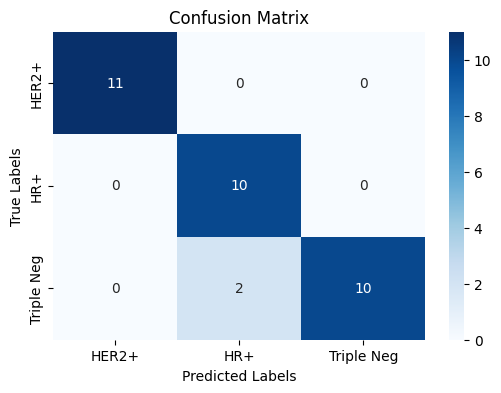

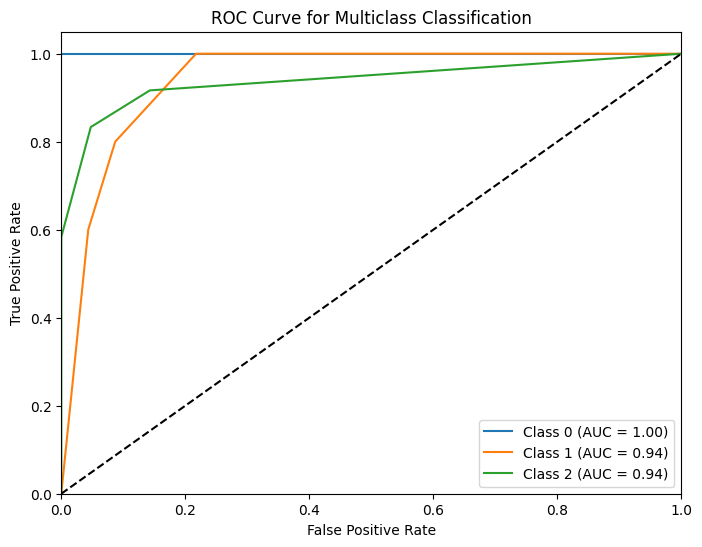

{'mean_accuracy': 0.8401663695781343,
 'std_accuracy': 0.05086377791808128,
 'best_model': KNeighborsClassifier(n_neighbors=3),
 'all_models': [KNeighborsClassifier(n_neighbors=3),
  KNeighborsClassifier(n_neighbors=3),
  KNeighborsClassifier(n_neighbors=1, p=1)]}

In [15]:
nested_cv_knn(X, y)

# List 4

In [16]:
# keep selected columns
list_4 = [2026, 2184, 2213]
new_df_X = df_X.iloc[:, list_4]

X = new_df_X.to_numpy()

## Logistic regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.73      0.80      0.76        10
           2       0.82      0.75      0.78        12

    accuracy                           0.85        33
   macro avg       0.85      0.85      0.85        33
weighted avg       0.85      0.85      0.85        33



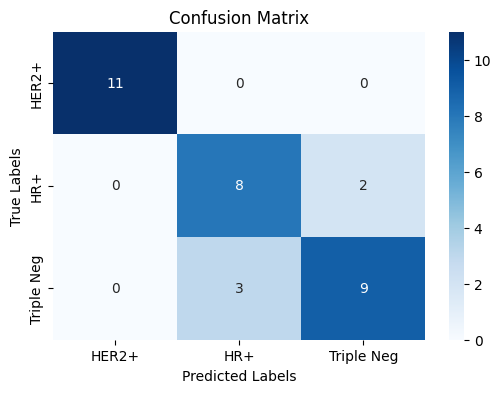

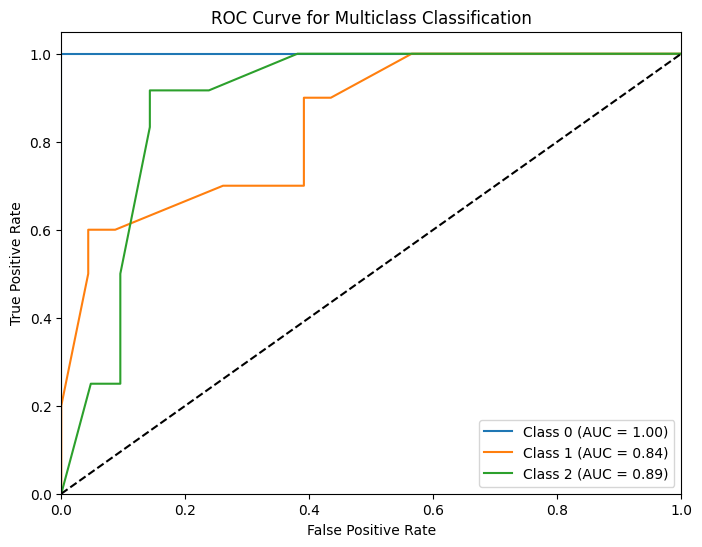

{'mean_accuracy': 0.700237670825906,
 'std_accuracy': 0.020868222612995768,
 'best_model': LogisticRegression(C=10, multi_class='ovr', penalty='l1', solver='liblinear'),
 'all_models': [LogisticRegression(C=1, multi_class='ovr', solver='liblinear'),
  LogisticRegression(C=10, multi_class='ovr', penalty='l1', solver='liblinear'),
  LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear')]}

In [17]:
nested_cv_logreg(X, y)

## kNN

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.75      0.60      0.67        10
           2       0.73      0.92      0.81        12

    accuracy                           0.82        33
   macro avg       0.83      0.81      0.81        33
weighted avg       0.83      0.82      0.82        33



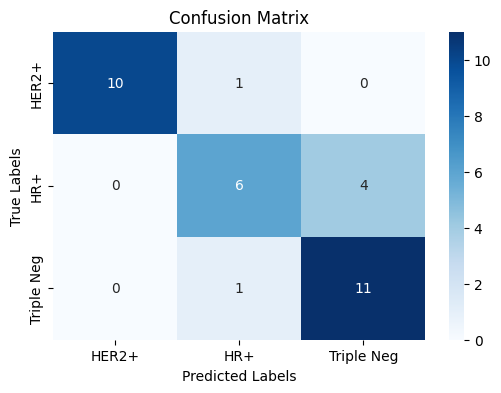

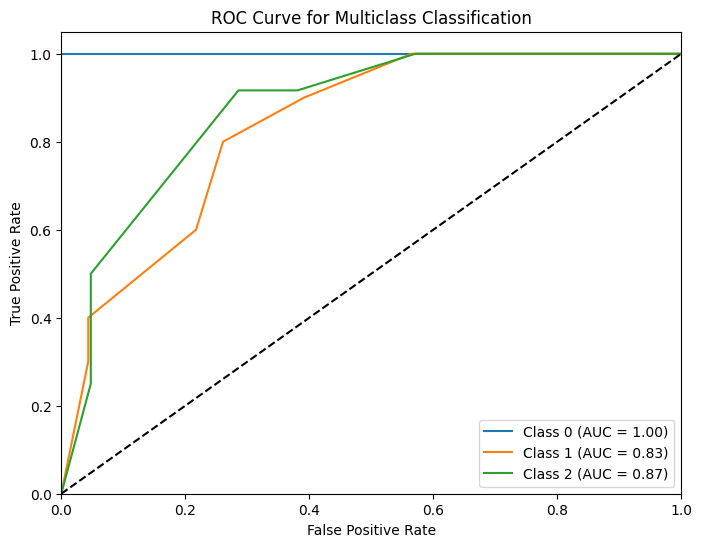

{'mean_accuracy': 0.6898395721925134,
 'std_accuracy': 0.016784844791236563,
 'best_model': KNeighborsClassifier(n_neighbors=9, p=1),
 'all_models': [KNeighborsClassifier(n_neighbors=9, p=1),
  KNeighborsClassifier(n_neighbors=9),
  KNeighborsClassifier(n_neighbors=11)]}

In [18]:
nested_cv_knn(X, y)

# List 5

In [19]:
# keep selected columns
list_5 = [2184]
new_df_X = df_X.iloc[:, list_5]

X = new_df_X.to_numpy()

## Logistic regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.45      1.00      0.62        10
           2       0.00      0.00      0.00        12

    accuracy                           0.64        33
   macro avg       0.48      0.67      0.54        33
weighted avg       0.47      0.64      0.52        33



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

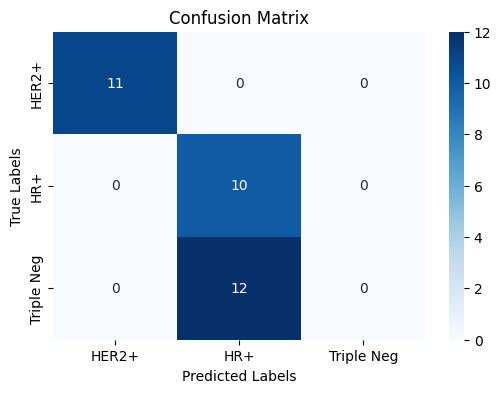

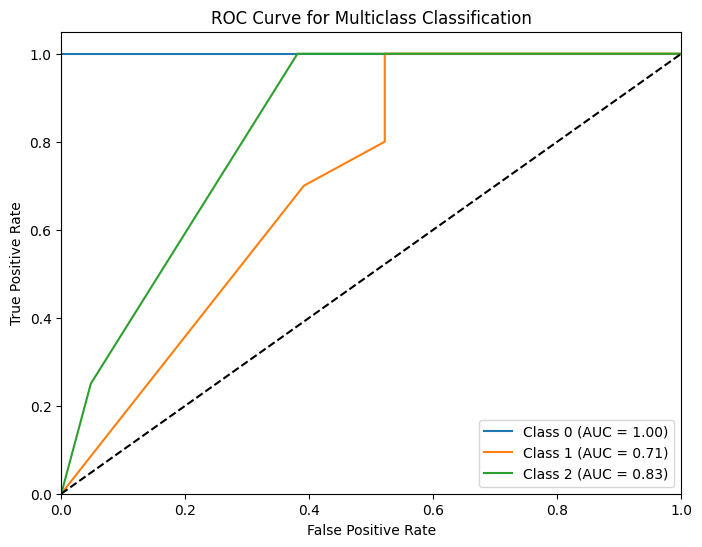

{'mean_accuracy': 0.5903149138443257,
 'std_accuracy': 0.033287175865547934,
 'best_model': LogisticRegression(C=10, multi_class='ovr', penalty='l1', solver='liblinear'),
 'all_models': [LogisticRegression(C=10, multi_class='ovr', penalty='l1', solver='liblinear'),
  LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear'),
  LogisticRegression(C=10, multi_class='ovr', penalty='l1', solver='liblinear')]}

In [20]:
nested_cv_logreg(X, y)

## kNN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.50      0.90      0.64        10
           2       0.75      0.25      0.38        12

    accuracy                           0.70        33
   macro avg       0.75      0.72      0.67        33
weighted avg       0.76      0.70      0.66        33



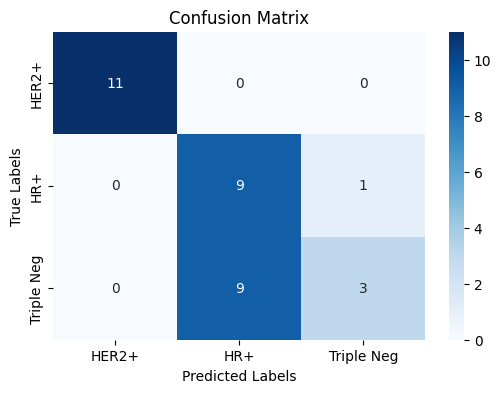

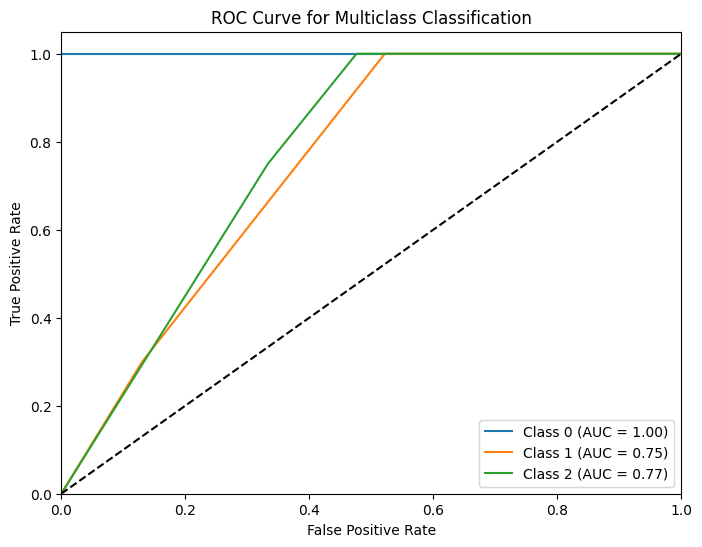

{'mean_accuracy': 0.6497326203208557,
 'std_accuracy': 0.018906598427447817,
 'best_model': KNeighborsClassifier(n_neighbors=7, p=1),
 'all_models': [KNeighborsClassifier(n_neighbors=7, p=1),
  KNeighborsClassifier(n_neighbors=9, p=1),
  KNeighborsClassifier(n_neighbors=1, p=1)]}

In [21]:
nested_cv_knn(X, y)